In [13]:
# Classical dependencies

# !pip3 install yfinance

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Formatting dates
import pandas as pd
import yfinance as yf #!pip install yfinance
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date # Date Functions
np.random.seed(4)

In [14]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [15]:
#
# Dataset reading Auto from yahoo finance
#

# With Portfolio
portfolio = ['BTC-USD', 'GLOB', 'DJI']

#Only one symbol
symbol = 'BTC-USD'

today = date.today()
date_today = today.strftime("%Y-%m-%d")
dataset = yf.download(symbol, end=date_today)

# # Create a quick overview of the dataset
dataset.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-05,27123.109375,27129.982422,25445.167969,25760.097656,25760.097656,21513292646
2023-06-06,25732.109375,27313.820312,25434.867188,27238.783203,27238.783203,21929670693
2023-06-07,27235.650391,27332.181641,26146.988281,26345.998047,26345.998047,19530045082
2023-06-08,26347.654297,26797.513672,26246.664062,26508.216797,26508.216797,11904824295
2023-06-09,26505.923828,26770.289062,26339.314453,26480.375000,26480.375000,11015551640


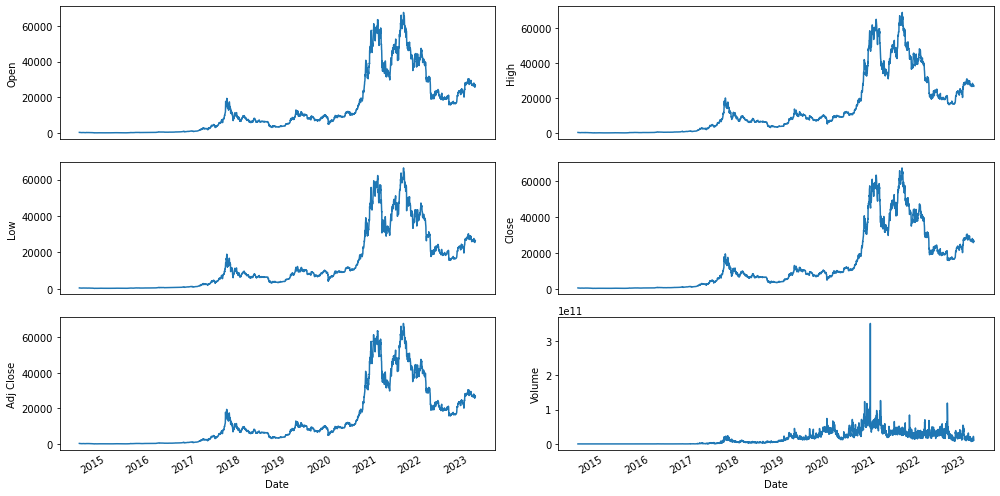

In [16]:
# Plot line charts
df_plot = dataset.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

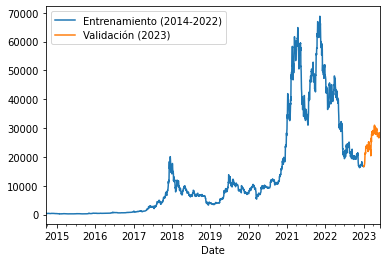

In [35]:
#
# Sets de entrenamiento y validación *** BTC-USD ***
# La LSTM se entrenará con datos de 2014 hacia atrás. La validación se hará con datos de 2021 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2022'].iloc[:,1:2]
set_validacion = dataset['2023':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2014-2022)', 'Validación (2023)'])
plt.show()

In [18]:
dataset['2023':].iloc[:,1:2]

,High
Date,
2023-01-01,16630.439453
2023-01-02,16759.343750
2023-01-03,16760.447266
2023-01-04,16964.585938
2023-01-05,16884.021484
...,...
2023-06-05,27129.982422
2023-06-06,27313.820312
2023-06-07,27332.181641


In [19]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3188.000000,3188.000000,3188.000000,3188.000000,3188.000000,3.188000e+03
mean,13470.137608,13801.144712,13105.810583,13476.914217,13476.914217,1.658581e+10
std,16021.591941,16424.679853,15559.168014,16018.335065,16018.335065,1.960238e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,744.051498,753.623001,734.401520,744.494995,744.494995,1.222412e+08
50%,7536.770264,7699.392090,7392.412598,7544.223389,7544.223389,9.789357e+09
75%,19626.130371,20139.581055,19273.825684,19644.679688,19644.679688,2.773166e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [20]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [36]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
# cant neurons
na = 1000

In [23]:
#
# Clasical Model Definition
#

# Define the LSTM model
model = Sequential()

# Add the first LSTM layer with dropout
model.add(LSTM(units=na, input_shape=dim_entrada, return_sequences=True))
model.add(Dropout(0.2))

# Add additional LSTM layers with dropout
for _ in range(1, 10):
    model.add(LSTM(units=na, return_sequences=True))
    model.add(Dropout(0.2))

# Add a final LSTM layer without return_sequences=True
model.add(LSTM(units=na))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=dim_salida))

# Compile the model
model.compile(optimizer='nadam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 1000)          4008000   
                                                                 
 dropout (Dropout)           (None, 60, 1000)          0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 1000)          8004000   
                                                                 
 dropout_1 (Dropout)         (None, 60, 1000)          0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 1000)          8004000   
                                                                 
 dropout_2 (Dropout)         (None, 60, 1000)          0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 1000)         

In [11]:
# Training
epochs = 20
history = model.fit(X_train,Y_train,epochs=epochs,batch_size=10)

Epoch 1/20
297/297 [==============================] - 62s 175ms/step - loss: 0.0092
Epoch 2/20
297/297 [==============================] - 49s 166ms/step - loss: 0.0048
Epoch 3/20
297/297 [==============================] - 50s 167ms/step - loss: 0.0035
Epoch 4/20
297/297 [==============================] - 50s 169ms/step - loss: 0.0029
Epoch 5/20
297/297 [==============================] - 52s 174ms/step - loss: 0.0021
Epoch 6/20
297/297 [==============================] - 52s 175ms/step - loss: 0.0018
Epoch 7/20
297/297 [==============================] - 50s 168ms/step - loss: 0.0017
Epoch 8/20
297/297 [==============================] - 49s 167ms/step - loss: 0.0012
Epoch 9/20
297/297 [==============================] - 50s 167ms/step - loss: 0.0011
Epoch 10/20
297/297 [==============================] - 50s 169ms/step - loss: 9.9274e-04
Epoch 11/20
297/297 [==============================] - 56s 187ms/step - loss: 8.8851e-04
Epoch 12/20
297/297 [==============================] - 58s 195ms/s

In [12]:
# Save the entire model
model.save('model_daily.h5')


# Validations

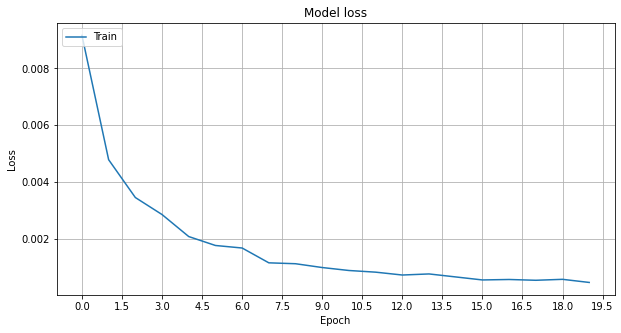

In [13]:
# *** daily ***

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [37]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = model.predict(X_test)


/Users/luis.ruiz/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


4/4 [==============================] - 3s 270ms/step


In [148]:
X_test.shape

(100, 60, 1)

In [ ]:
set_validacion.values

In [15]:
# Reshape the prediccion array
prediccion = np.reshape(prediccion, 100)

# Apply inverse_transform to the prediccion array
prediccion = sc.inverse_transform([prediccion])
prediccion = prediccion[0]

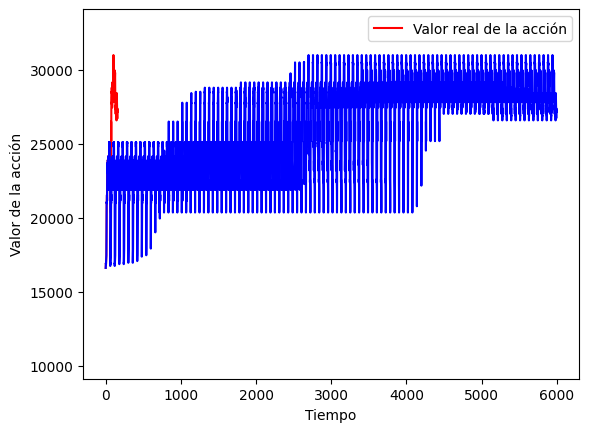

In [66]:
# resultados con 100 epochs 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

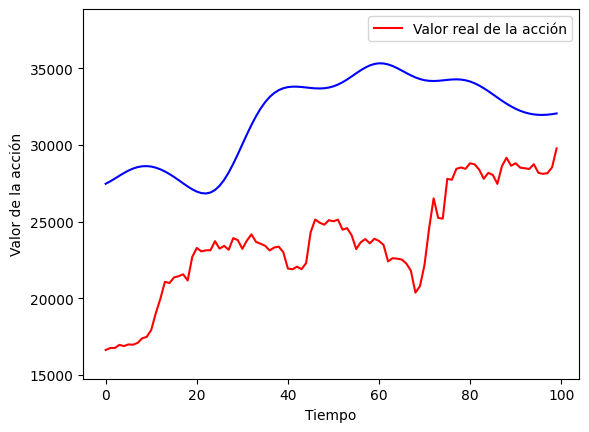

In [73]:
# resultados con 10 epochs Modelo Clasico test data: 2014-2021, 2022 - 10 neuronas
graficar_predicciones(set_validacion.values,prediccion)

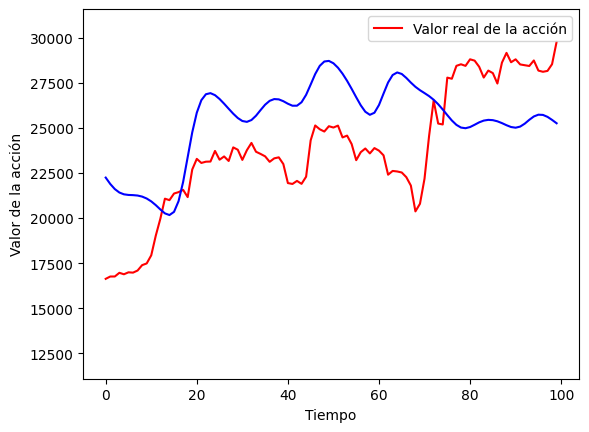

In [79]:
# resultados con 20 epochs Modelo Clasico test data: 2014-2021, 2022 - 10 neuronas
graficar_predicciones(set_validacion.values,prediccion)

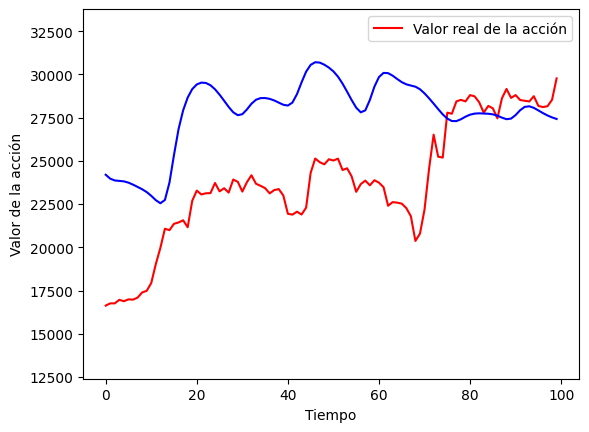

In [85]:
# resultados con 30 epochs - 10 neuronas
graficar_predicciones(set_validacion.values,prediccion)

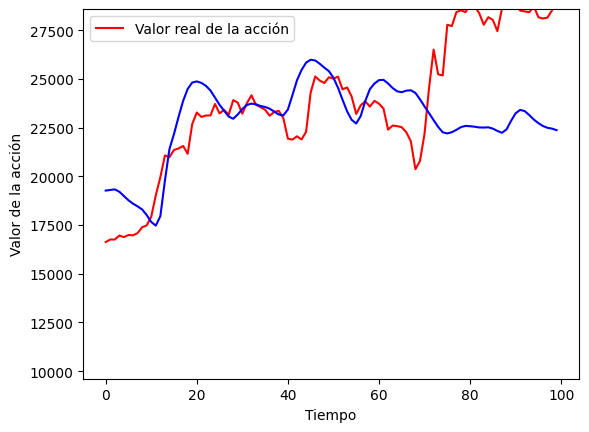

In [92]:
# resultados con 50 epochs - 10 neuronas
graficar_predicciones(set_validacion.values,prediccion)

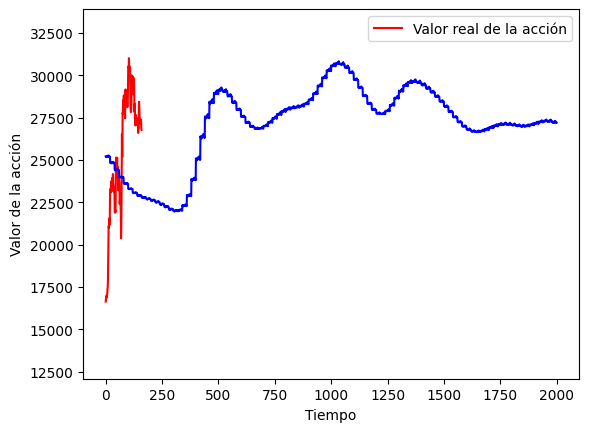

In [102]:
# resultados con 70 - 10 neuronas
graficar_predicciones(set_validacion.values,prediccion)

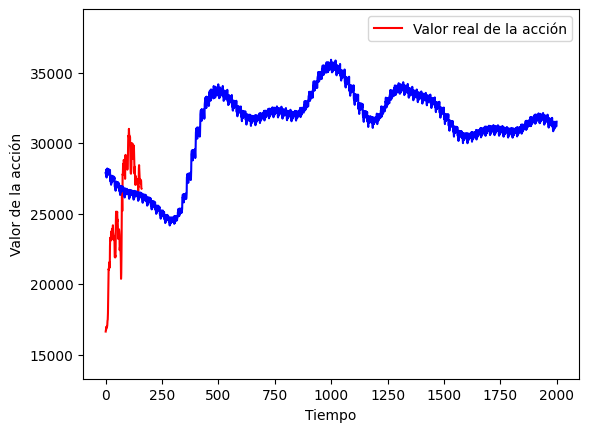

In [114]:
# resultados con 50 epochs - 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

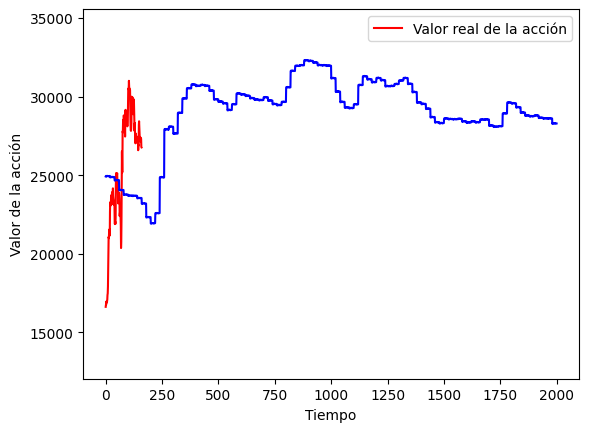

In [122]:
# resultados con 50 epochs - 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

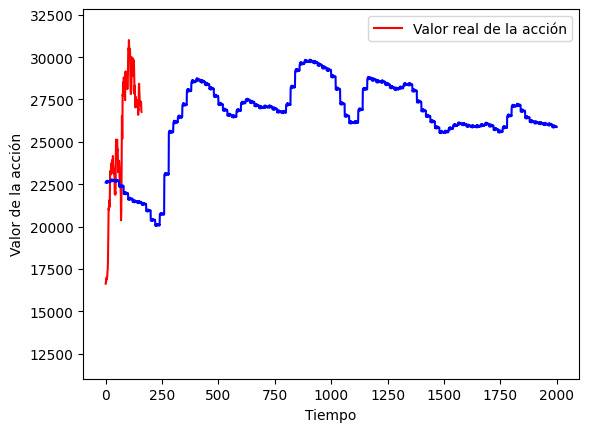

In [130]:
# resultados con 30 epochs - 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

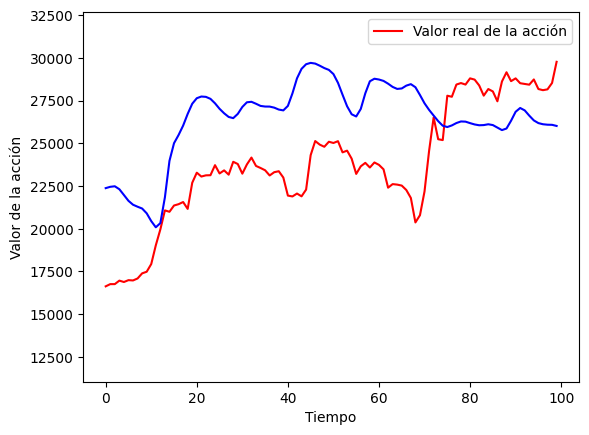

In [142]:
# resultados con 30 epochs - 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

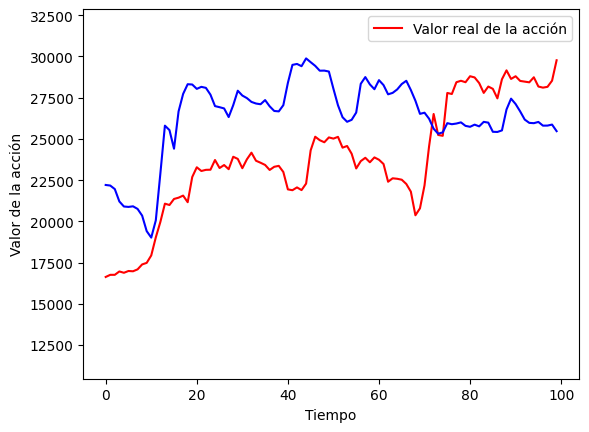

In [150]:
# resultados con 70 epochs - 50 neuronas
graficar_predicciones(set_validacion.values,prediccion)

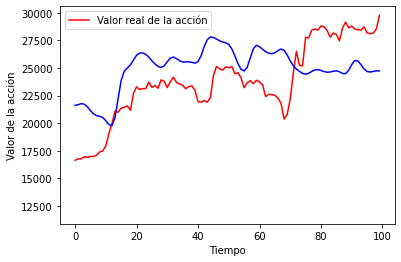

In [17]:
# resultados con 20 epochs - 1000 neuronas
graficar_predicciones(set_validacion.values,prediccion)

** Mensual Model **

In [27]:
from tensorflow.keras.models import load_model
# Función para cargar el modelo
def load_trained_model():
    try:
        # Ruta donde se encuentra el modelo entrenado
        model_path = 'model_daily.h5'
        # Cargar el modelo
        model = load_model(model_path, custom_objects={})
        print('model loaded')
        return model
    # Manejar errores
    except Exception as err:
        return {"Eror Loading Model: ": str(err)}

In [33]:
# Load the trained model
loaded_model = load_trained_model()

model loaded


In [42]:
X_test

array([[[0.23941692],
        [0.2412966 ],
        [0.24131269],
        ...,
        [0.34480732],
        [0.34083365],
        [0.34513894]],

       [[0.2412966 ],
        [0.24131269],
        [0.24428943],
        ...,
        [0.34083365],
        [0.34513894],
        [0.34307568]],

       [[0.24131269],
        [0.24428943],
        [0.24311465],
        ...,
        [0.34513894],
        [0.34307568],
        [0.33928742]],

       ...,

       [[0.4075385 ],
        [0.41297709],
        [0.43103881],
        ...,
        [0.39656057],
        [0.39252082],
        [0.39520154]],

       [[0.41297709],
        [0.43103881],
        [0.44179474],
        ...,
        [0.39252082],
        [0.39520154],
        [0.39546928]],

       [[0.43103881],
        [0.44179474],
        [0.44111517],
        ...,
        [0.39520154],
        [0.39546928],
        [0.38767278]]])

In [39]:
pred_test = model.predict(X_test)

4/4 [==============================] - 0s 81ms/step


In [40]:
# Reshape the prediccion array
prediccion = np.reshape(pred_test, 100)

# Apply inverse_transform to the prediccion array
prediccion = sc.inverse_transform([prediccion])
prediccion = prediccion[0]

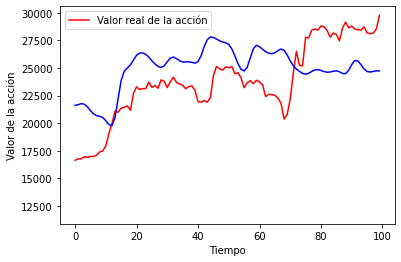

In [41]:
# resultados con 100 epochs 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)

### **Hybrid Results 🔥**

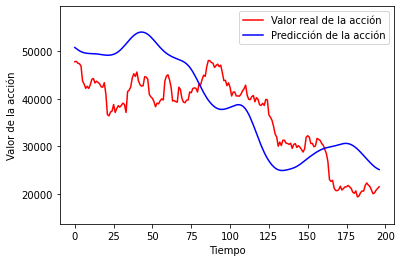

In [ ]:
# resultados con 10 epochs Modelo Hibrido - 2 qubits 3.5hrs aprox
graficar_predicciones(set_validacion.values,prediccion)

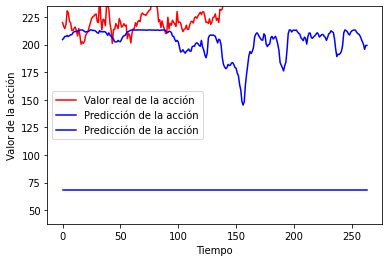

In [ ]:
# resultados con 100 epochs - 2 qubits Modelo Hibrido - 3.5hrs aprox
graficar_predicciones(set_validacion.values,prediccion)

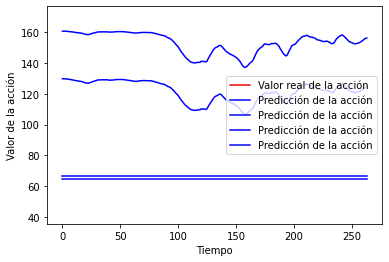

In [ ]:
# resultados con 10 epochs - 4 qubits Modelo Hibrido - 45min~
graficar_predicciones(set_validacion.values,prediccion)

In [ ]:
# resultados con 10 epochs Modelo Clasico test data: 2014-2021, 2022 - 100 neuronas
graficar_predicciones(set_validacion.values,prediccion)